In [0]:
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#read the file
df = pd.read_csv("finaln50.csv")

#print the head
df.dropna(inplace=True)
df.head()



,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,4675.799805,4773.100098,4675.799805,4765.299805,4765.299805,0.0
1,2012-01-04,4774.950195,4782.850098,4728.850098,4749.649902,4749.649902,0.0
2,2012-01-05,4749.000000,4779.799805,4730.149902,4749.950195,4749.950195,0.0
3,2012-01-06,4724.149902,4794.899902,4686.850098,4754.100098,4754.100098,0.0
5,2012-01-09,4747.549805,4758.700195,4695.450195,4742.799805,4742.799805,0.0


In [0]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [0]:
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#sorting
data = df.sort_index(ascending=True, axis=0)

#creating a separate dataset
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

dataset

array([[4765.299805],
       [4749.649902],
       [4749.950195],
       ...,
       [11945.900391],
       [11922.799805],
       [12088.549805]], dtype=object)

In [0]:
train = dataset[0:1711,:]
valid = dataset[1711:1810,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

Epoch 1/1
 - 98s - loss: 0.0023


In [0]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

154.40437893718575

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 0, 'Trading day')

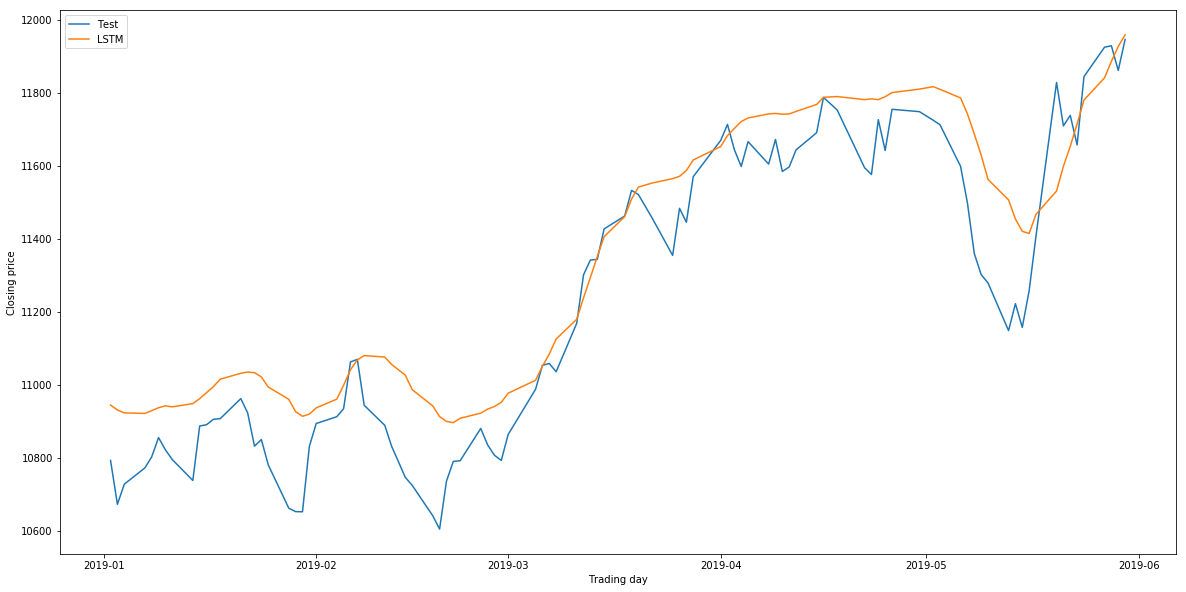

In [0]:
train = new_data[:1711]
valid = new_data[1711:1810]
valid['Predictions'] = closing_price
plt.plot(valid['Close'],label='Test')
plt.plot(valid['Predictions'],label='LSTM')
plt.legend(loc='best')
plt.ylabel('Closing price')
plt.xlabel('Trading day')